In [767]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import statsmodels.api as sm
import folium

matplotlib.rcParams['xtick.labelsize']=20
matplotlib.rcParams['ytick.labelsize']=20


# Seattle data
Let's import and investigate the Seattle data and see if we can use any of it and what modifications would be necessary. 

In [690]:
#Import Listings
df_seattle_list = pd.read_csv('input/seattle/listings.csv')
print(df_seattle_list.shape)
df_seattle_list.head(5)

(3818, 92)


id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  \
0                                                NaN   
1  Queen Anne is a wonderful, truly functional vi...   
2  Upper Queen Anne is a charming neighborhood fu...   
3                                                NaN   
4  We are in the beautiful neighborhood of Queen ...   

                                               notes  \
0                                                NaN   
1  What's up with the free pillows?  Our home was...   
2  Our house is located just 5 short blocks to To...   
3                                                NaN   
4                                          Belltown    

                                             transit  \
0                                                NaN   
1  Convenient bus stops are just down the block, ...   
2  A bus stop is just 2 blocks away.   Easy bus a...   
3                                                NaN   
4  The nearest public transit bus (D Line) is 2 b...   

                                       thumbnail_url  \
0                                                NaN   
1  https://a0.muscache.com/ac/pictures/14409893/f...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                          medium_url  \
0                                                NaN   
1  https://a0.muscache.com/im/pictures/14409893/f...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         picture_url  \
0  https://a1.muscache.com/ac/pictures/67560560/c...   
1  https://a0.muscache.com/ac/pictures/14409893/f...   
2  https://a2.muscache.com/ac/pictures/b4324e0f-a...   
3  https://a0.muscache.com/ac/pictures/94146944/6...   
4  https://a1.muscache.com/ac/pictures/6120468/b0...   

                                      xl_picture_url   host_id  \
0                                                

In [691]:
#Import calendar.csv
df_seattle_cal = pd.read_csv('input/seattle/calendar.csv', parse_dates=[1])
print(df_seattle_cal.shape)
df_seattle_cal.head(5)

(1393570, 4)


listing_id       date available   price
0      241032 2016-01-04         t  $85.00
1      241032 2016-01-05         t  $85.00
2      241032 2016-01-06         f     NaN
3      241032 2016-01-07         f     NaN
4      241032 2016-01-08         f     NaN

In [692]:
#import reviews 
df_seattle_rev = pd.read_csv('input/seattle/reviews.csv', parse_dates=[2])
print(df_seattle_rev.shape)
df_seattle_rev.head(5)

(84849, 6)


listing_id        id       date  reviewer_id reviewer_name  \
0     7202016  38917982 2015-07-19     28943674        Bianca   
1     7202016  39087409 2015-07-20     32440555         Frank   
2     7202016  39820030 2015-07-26     37722850           Ian   
3     7202016  40813543 2015-08-02     33671805        George   
4     7202016  41986501 2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

Lets dive into the listings dataframe in more detail to understand what is actually there. It seems the calendar and reviews dataframe are useful as metadata if we want to dig deep into the matter, but we will wait a bit with this now.

## Listings 

First thing we need to understand more of what data are available in the columns in the listings. Some of the data can probably be discarded right away, or kept in the background until we need more nuanced insights, while other columns should be our main pillars of knowledge.

Let's first see if some columns are practically without information

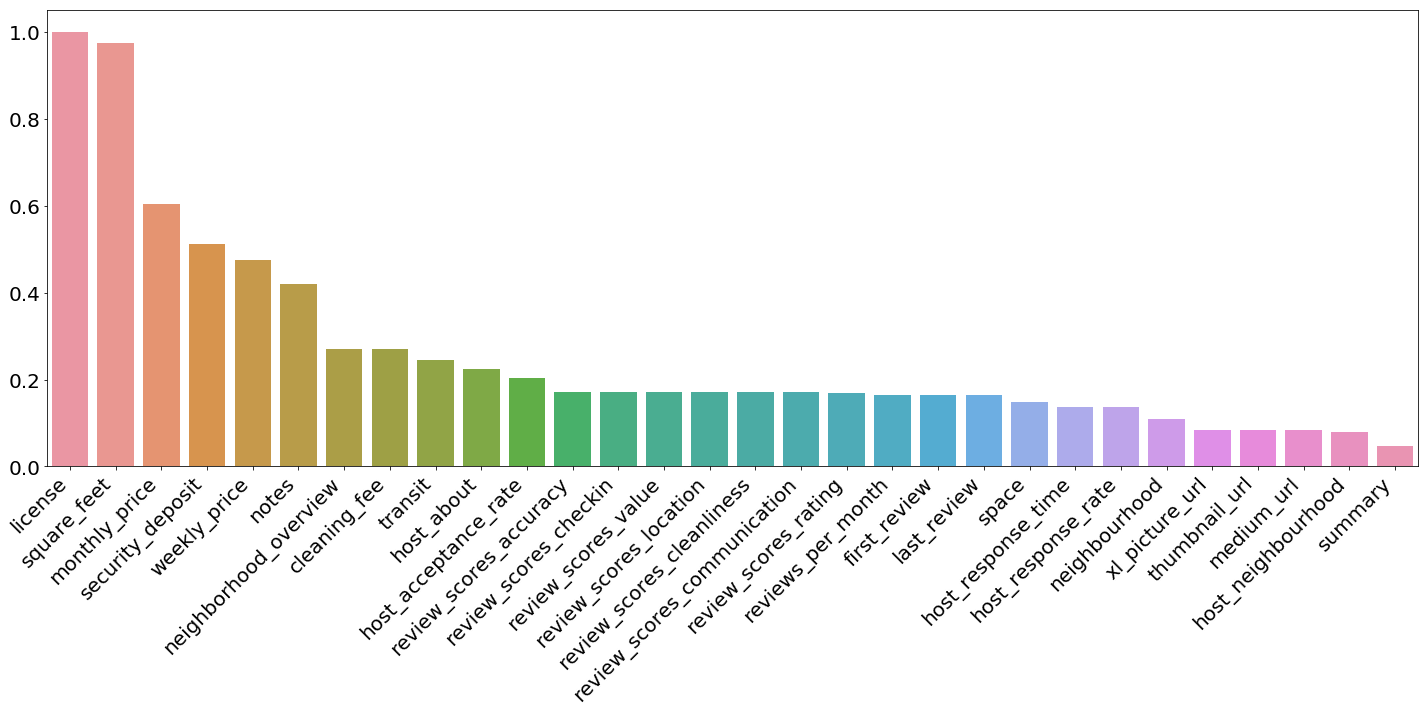

In [693]:
missing_list = (1-df_seattle_list.count()/df_seattle_list.shape[0]).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=missing_list[missing_list>0.01].index, y = missing_list[missing_list>0.01] , ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
plt.tight_layout()
#ax.set_ylabel('Missing values ratio', size=15)

First of all we can see from this that the license are missing for all. When looking closer at the columns, there is a column called "requires_license". This seems to be all false, hence there is little information about the license and we can add both of those to a list of columns to drop for Seattle. However, that does not mean it can be dropped for other cities.

Anyway, any column that have one unique value will not provide any additional information about the host or client or anything else, it is equal for all our datapoints. So we will first find all those columns and see how many and what they are, and ditch them. 

In [694]:
pd.set_option('display.max_rows', 1000)
(df_seattle_list.count()/df_seattle_list.shape[0]).sort_values()

license                             0.000000
square_feet                         0.025406
monthly_price                       0.397328
security_deposit                    0.488738
weekly_price                        0.526192
notes                               0.579361
neighborhood_overview               0.729701
cleaning_fee                        0.730225
transit                             0.755369
host_about                          0.775013
host_acceptance_rate                0.797538
review_scores_checkin               0.827658
review_scores_accuracy              0.827658
review_scores_value                 0.828182
review_scores_location              0.828444
review_scores_cleanliness           0.828968
review_scores_communication         0.829492
review_scores_rating                0.830540
last_review                         0.835778
first_review                        0.835778
reviews_per_month                   0.835778
space                               0.850969
host_respo

Text(0, 0.5, 'Number of unique entries')

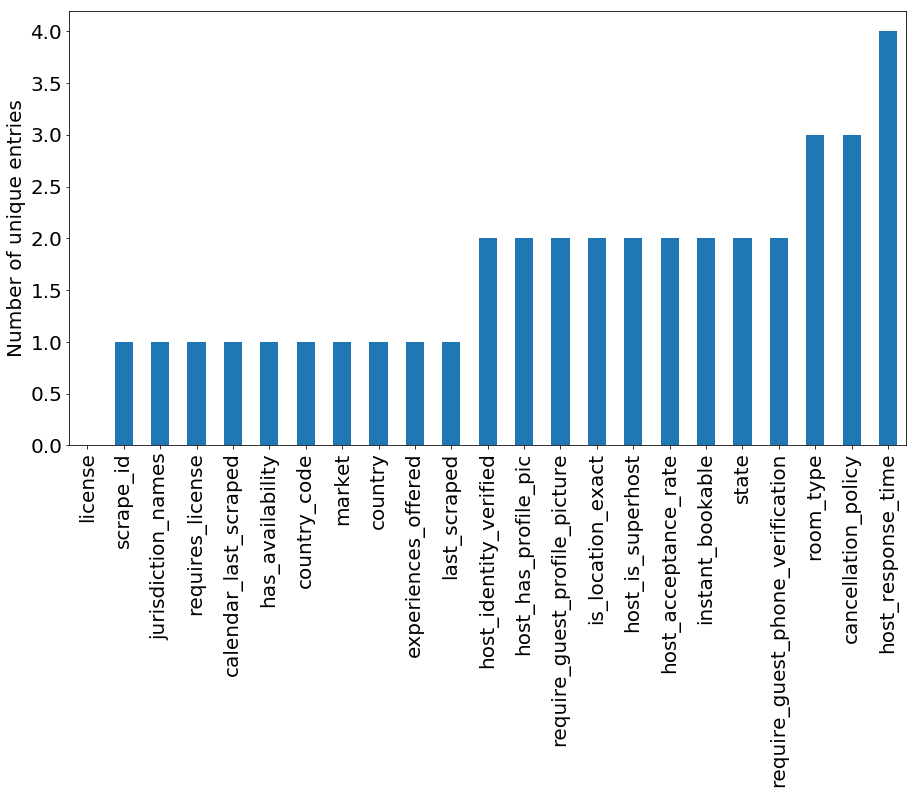

In [695]:
ax = df_seattle_list.nunique()[df_seattle_list.nunique()<5].sort_values().plot(kind='bar', figsize=(15,8))
ax.set_ylabel('Number of unique entries', fontsize=20)

Lets remove the uninformative columns right away

In [696]:
df_seattle_list_reduced = df_seattle_list.drop(labels=df_seattle_list.nunique()[df_seattle_list.nunique()<2].index, axis=1)
df_seattle_list_reduced.shape

(3818, 81)

Lets also look at the other end of the scale, the columns that has basically all unique values. No overlapping ones. 

Text(0, 0.5, 'Unique ratio')

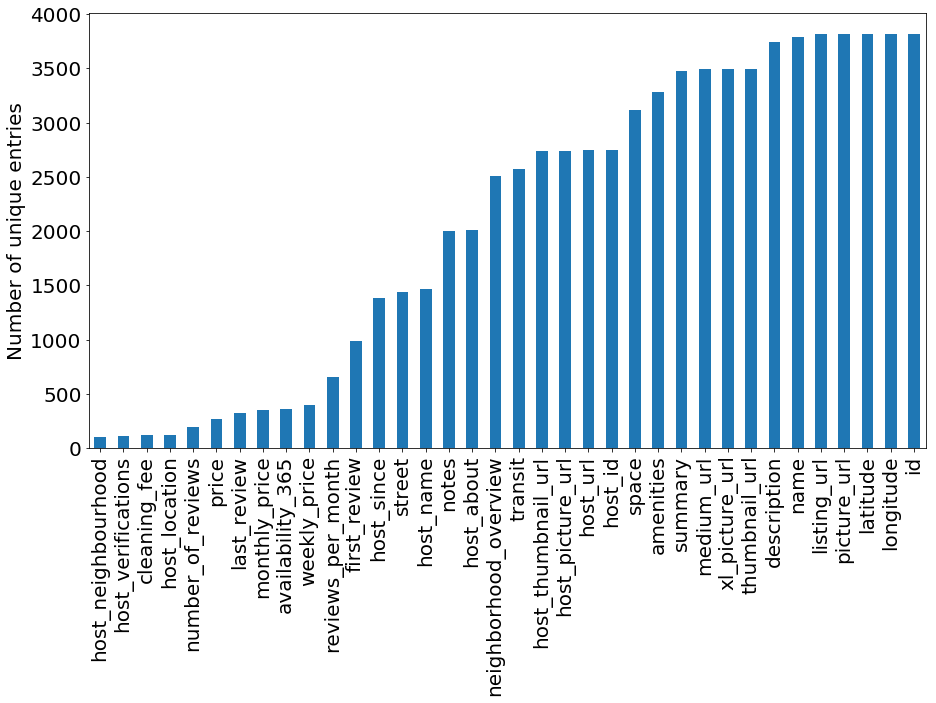

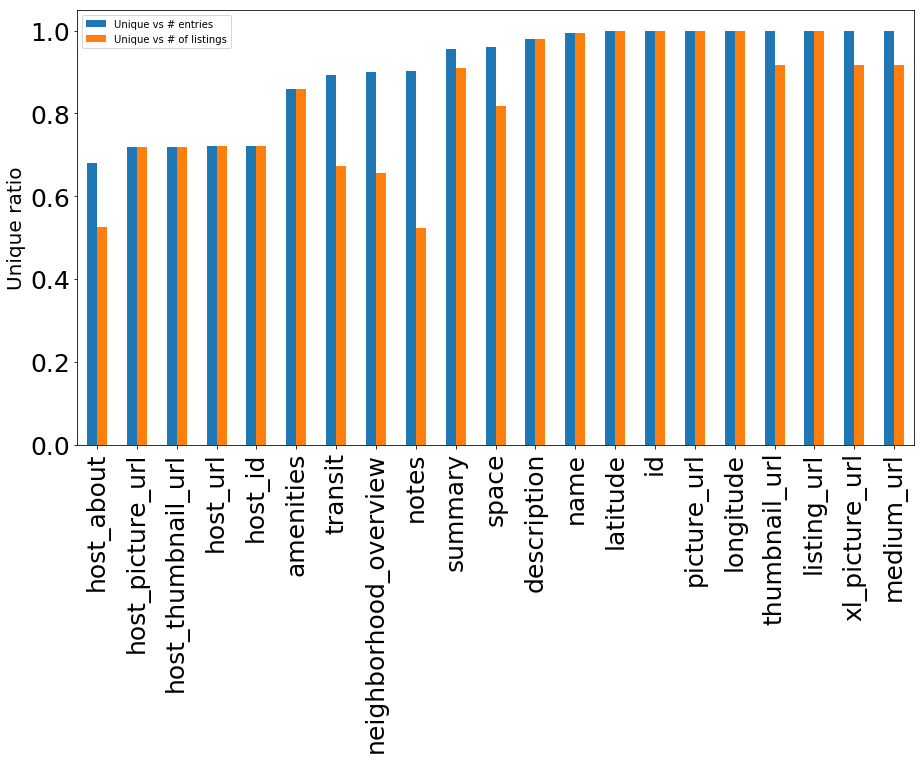

In [697]:
ax = (df_seattle_list.nunique())[df_seattle_list.nunique()>100].sort_values().plot(kind='bar', figsize=(15,8))
#(df_seattle_list.nunique()/df_seattle_list.shape[0])[df_seattle_list.nunique()>100].sort_values().plot(kind='bar', figsize=(15,8), ax=ax)
ax.set_ylabel('Number of unique entries', fontsize=20)
df_unique_ratios = pd.DataFrame({'Unique vs # entries': df_seattle_list.nunique()/df_seattle_list.count(), 'Unique vs # of listings': df_seattle_list.nunique()/df_seattle_list.shape[0]})
ax2 = df_unique_ratios[df_unique_ratios['Unique vs # entries']>0.5].sort_values('Unique vs # entries').plot(kind='bar', figsize=(15,8), fontsize=25)
ax2.set_ylabel('Unique ratio', fontsize=20)

We can see that the ratio of unique values change slightly if we related it to actual number of entries. 

We can see that there are quite some columns that would not give any useful information as they are all different.

Latitude and Longitude are also among the columns with all unique values. These are expected to be unique and still give insight, thus these cannot be removed. However, it will not matter much what url people use for their pics, unless, maybe, there is a difference if they have pictures or not... Again, we can see that all has a picture url (further up), and all is unique, so not much to gain from this. 

We can also see that less than 80% of number of listings with a host (probably every listing) have a unique host. The rest of the listings are then hosted by the same person having more than one listing. 



To ease our pain, we will remove the columns with all unique values (except for latitude and longitude, also id can be useful if we want to use the calendar and review data).

In [698]:
all_unique_cols = df_unique_ratios[df_unique_ratios['Unique vs # entries']==1]
all_unique_cols = all_unique_cols.drop(labels=['latitude', 'longitude', 'id'], axis=0).index
all_unique_cols
df_seattle_list_reduced = df_seattle_list_reduced.drop(labels=all_unique_cols, axis=1)
df_seattle_list_reduced.shape

(3818, 76)

As seen above, there are still 75 columns after removing columns without information and we need to go deeper into some of them to see what they are. Lets first check quickly what the different columns type is. 

In [699]:
df_seattle_list_reduced.get_dtype_counts()

int64      12
object     48
float64    16
dtype: int64

We can see that 16 of them are floats, while 12 is integers. Floats are usually numerical continous values, but could also be ordinal or categorical if not formatted properly. Integers are probably both categorical and ordinal values, but we will look further into the different ones. The object group is here a mix of text boxes and categorical values. As we saw from the number of unique entries above, there are several columns that has a limited number of entries, and thus is a categorical or ordinal value and not free text, or free numbers. 

First, a look at the floats

In [700]:
df_list_float = df_seattle_list_reduced.select_dtypes(include='float')
df_list_float.head(5)

host_listings_count  host_total_listings_count   latitude   longitude  \
0                  3.0                        3.0  47.636289 -122.371025   
1                  6.0                        6.0  47.639123 -122.365666   
2                  2.0                        2.0  47.629724 -122.369483   
3                  1.0                        1.0  47.638473 -122.369279   
4                  2.0                        2.0  47.632918 -122.372471   

   bathrooms  bedrooms  beds  square_feet  review_scores_rating  \
0        1.0       1.0   1.0          NaN                  95.0   
1        1.0       1.0   1.0          NaN                  96.0   
2        4.5       5.0   7.0          NaN                  97.0   
3        1.0       0.0   2.0          NaN                   NaN   
4        2.0       3.0   3.0          NaN                  92.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    10.0                       10.0                   10.0   
1                    10.0                       10.0                   10.0   
2                    10.0                       10.0                   10.0   
3                     NaN                        NaN                    NaN   
4                     9.0                        9.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                     9.0                 10.0   
1                         10.0                    10.0                 10.0   
2                         10.0                    10.0                 10.0   
3                          NaN                     NaN                  NaN   
4                         10.0                     9.0                  9.0   

   reviews_per_month  
0               4.07  
1               1.48  
2               1.15  
3                NaN  
4               0.89

In [701]:
print(df_list_float.shape)
df_list_float.describe()

(3818, 16)


host_listings_count  host_total_listings_count     latitude  \
count          3816.000000                3816.000000  3818.000000   
mean              7.157757                   7.157757    47.628961   
std              28.628149                  28.628149     0.043052   
min               1.000000                   1.000000    47.505088   
25%               1.000000                   1.000000    47.609418   
50%               1.000000                   1.000000    47.623601   
75%               3.000000                   3.000000    47.662694   
max             502.000000                 502.000000    47.733358   

         longitude    bathrooms     bedrooms         beds  square_feet  \
count  3818.000000  3802.000000  3812.000000  3817.000000    97.000000   
mean   -122.333103     1.259469     1.307712     1.735394   854.618557   
std       0.031745     0.590369     0.883395     1.139480   671.404893   
min    -122.417219     0.000000     0.000000     1.000000     0.000000   
25%    -122.354320     1.000000     1.000000     1.000000   420.000000   
50%    -122.328874     1.000000     1.000000     1.000000   750.000000   
75%    -122.310800     1.000000     2.000000     2.000000  1200.000000   
max    -122.240607     8.000000     7.000000    15.000000  3000.000000   

       review_scores_rating  review_scores_accuracy  \
count           3171.000000             3160.000000   
mean              94.539262                9.636392   
std                6.606083                0.698031   
min               20.000000                2.000000   
25%               93.000000                9.000000   
50%               96.000000               10.000000   
75%               99.000000               10.000000   
max              100.000000               10.000000   

       review_scores_cleanliness  review_scores_checkin  \
count                3165.000000            3160.000000   
mean                    9.556398               9.786709   
std                     0.797274               0.595499   
min                     3.000000               2.000000   
25%                     9.000000              10.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       review_scores_communication  review_scores_location  \
count                  3167.000000             3163.000000   
mean                      9.809599                9.608916   
std                       0.568211                0.629053   
min                       2.000000                4.000000   
25%                      10.000000                9.000000   
50%                      10.000000               10.000000   
75%                      10.000000               10.000000   
max                      10.000000               10.000000   

       review_scores_value  reviews_per_month  
count          3162.000000        3191.000000  
mean              9.452245           2.078919  
std               0.750259           1.822348  
min               2.000000           0.020000  
25%               9.000000           0.695000  
50%              10.000000           1.540000  
75%              10.000000           3.000000  
max              10.000000          12.150000

The latitude and longitude is probably not that interesting given that we have the neighborhood. However, we saw above that quite some listings lacked the neighborhood and thus it could be interesting to use the position to estimate location. 

Also, the square feet, which could be interesting in general, seem to not be very easy to impute as most listings lack the data for it. 

Otherwise, we will keep the rest of the columns for now. 

Let's have a look at the integer columns

In [702]:
df_list_int = df_seattle_list_reduced.select_dtypes(include='integer')
df_list_int.head(5)

id   host_id  accommodates  guests_included  minimum_nights  \
0   241032    956883             4                2               1   
1   953595   5177328             4                1               2   
2  3308979  16708587            11               10               4   
3  7421966   9851441             3                1               1   
4   278830   1452570             6                6               1   

   maximum_nights  availability_30  availability_60  availability_90  \
0             365               14               41               71   
1              90               13               13               16   
2              30                1                6               17   
3            1125                0                0                0   
4            1125               30               60               90   

   availability_365  number_of_reviews  calculated_host_listings_count  
0               346                207                               2  
1               291                 43                               6  
2               220                 20                               2  
3               143                  0                               1  
4               365                 38                               1

In [703]:
print(df_list_int.shape)
df_list_int.describe()

(3818, 12)


id       host_id  accommodates  guests_included  \
count  3.818000e+03  3.818000e+03   3818.000000      3818.000000   
mean   5.550111e+06  1.578556e+07      3.349398         1.672603   
std    2.962660e+06  1.458382e+07      1.977599         1.311040   
min    3.335000e+03  4.193000e+03      1.000000         0.000000   
25%    3.258256e+06  3.275204e+06      2.000000         1.000000   
50%    6.118244e+06  1.055814e+07      3.000000         1.000000   
75%    8.035127e+06  2.590309e+07      4.000000         2.000000   
max    1.034016e+07  5.320861e+07     16.000000        15.000000   

       minimum_nights  maximum_nights  availability_30  availability_60  \
count     3818.000000     3818.000000      3818.000000      3818.000000   
mean         2.369303      780.447617        16.786276        36.814825   
std         16.305902     1683.589007        12.173637        23.337541   
min          1.000000        1.000000         0.000000         0.000000   
25%          1.000000       60.000000         2.000000        13.000000   
50%          2.000000     1125.000000        20.000000        46.000000   
75%          2.000000     1125.000000        30.000000        59.000000   
max       1000.000000   100000.000000        30.000000        60.000000   

       availability_90  availability_365  number_of_reviews  \
count      3818.000000       3818.000000        3818.000000   
mean         58.082504        244.772656          22.223415   
std          34.063845        126.772526          37.730892   
min           0.000000          0.000000           0.000000   
25%          28.000000        124.000000           2.000000   
50%          73.000000        308.000000           9.000000   
75%          89.000000        360.000000          26.000000   
max          90.000000        365.000000         474.000000   

       calculated_host_listings_count  
count                     3818.000000  
mean                         2.946307  
std                          5.893029  
min                          1.000000  
25%                          1.000000  
50%                          1.000000  
75%                          2.000000  
max                         37.000000

The integer columns seems to be all filled up and no big issues, there are no ordinal values hidden here. Hence, I will keep all the columns for now and start to look at the forest of object columns

In [704]:
df_list_obj = df_seattle_list_reduced.select_dtypes(include='object')
pd.options.display.max_columns = 500
df_list_obj.head(5)

name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description  \
0  Make your self at home in this charming one-be...   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                               neighborhood_overview  \
0                                                NaN   
1  Queen Anne is a wonderful, truly functional vi...   
2  Upper Queen Anne is a charming neighborhood fu...   
3                                                NaN   
4  We are in the beautiful neighborhood of Queen ...   

                                               notes  \
0                                                NaN   
1  What's up with the free pillows?  Our home was...   
2  Our house is located just 5 short blocks to To...   
3                                                NaN   
4                                          Belltown    

                                             transit  \
0                                                NaN   
1  Convenient bus stops are just down the block, ...   
2  A bus stop is just 2 blocks away.   Easy bus a...   
3                                                NaN   
4  The nearest public transit bus (D Line) is 2 b...   

                                     host_url host_name  host_since  \
0    https://www.airbnb.com/users/show/956883     Maija  2011-08-11   
1   https://www.airbnb.com/users/show/5177328    Andrea  2013-02-21   
2  https://www.airbnb.com/users/show/16708587      Jill  2014-06-12   
3   https://www.airbnb.com/users/show/9851441     Emily  2013-11-06   
4   https://www.airbnb.com/users/show/1452570     Emily  2011-11-29   

                        host_location  \
0  Seattle, Washington, United States   
1  Seattle, Washington, United States   
2  Seattle, Washington, United States   
3  Seattle, Washington, United States   
4  Seattle, Washington, United States   

                                          host_about  host_response_time  \
0  I am an artist, interior designer, and run a s...  within a few hours   
1  Living east coast/left coast/overseas.  Time i...      within an hour   
2  i love living in Seattle.  i grew up in the mi...  within a few hours   
3                                                NaN                 NaN   
4  Hi, I live in Seattle, Washington but I'm orig...      within an hour   

  host_response_rate host_acceptance_rate host_is_superhost  \
0                96%                 100%                 f   
1                98%                 100%                 t   
2                67%                 100%                 f   
3                NaN                  NaN                 f   
4               100%                  NaN                 f   

                                  host_thumbnail_url  \
0  https://a0.muscache.com/ac/users/956883/profil...   
1  https://a0.muscache.com/ac/users/5177328/profi...   
2  https://a1.muscache.com/ac/users/16708587/prof...   
3  https://a2.muscache.co

In [705]:
print(df_list_obj.shape)
df_list_obj.describe()

(3818, 48)


name  \
count                     3818   
unique                    3792   
top     Capitol Hill Apartment   
freq                         3   

                                                  summary  \
count                                                3641   
unique                                               3478   
top     This is a modern fully-furnished studio apartm...   
freq                                                   15   

                                                    space  \
count                                                3249   
unique                                               3119   
top     *Note: This fall, there will be major renovati...   
freq                                                   14   

                                              description  \
count                                                3818   
unique                                               3742   
top     Our space is a mix of a hostel and a home. We ...   
freq                                                   10   

                                    neighborhood_overview  \
count                                                2786   
unique                                               2506   
top     Wallingford is a mostly-residential neighborho...   
freq                                                   17   

                                                    notes  \
count                                                2212   
unique                                               1999   
top     All of our rentals are fully licensed and regu...   
freq                                                   39   

                                                  transit  \
count                                                2884   
unique                                               2574   
top     Convenient public transportation. The location...   
freq                                                   32   

                                         host_url host_name  host_since  \
count                                        3818      3816        3816   
unique                                       2751      1466        1380   
top     https://www.airbnb.com/users/show/8534462    Andrew  2013-08-30   
freq                                           46        56          51   

                             host_location  \
count                                 3810   
unique                                 120   
top     Seattle, Washington, United States   
freq                                  3259   

                                               host_about host_response_time  \
count                                                2959               3295   
unique                                               2011                  4   
top     It would be my pleasure to share and explore t...     within an hour   
freq                                                   46               1692   

       host_response_rate host_acceptance_rate host_is_superhost  \
count                3295                 3045              3816   
unique                 45                    2                 2   
top                  100%                 100%                 f   
freq                 2371                 3044              3038   

                                       host_thumbnail_url  \
count                                                3816   
unique                                               2743   
top     https://a2.muscache.com/ac/pictures/a4d7d053-c...   
freq                                                   46   

                                         host_picture_url host_neighbourhood  \
count                                                3816               3518   
unique                                               2743                102   
top     https://a2.muscache.com/ac/pictures/a4d7d053-c...       Capitol Hill   
freq                                        

Not all of these columns would be interesting in the first round of investigation, although quite some are. Firstly, I will drop free text fields which would need significant NLP efforts to extract wisdom from. The typical drop down menu columns will be converted to categorical or ordinal columns. 

In [706]:
drop_columns = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'host_url',
                'host_name', 'host_location', 'host_about','host_thumbnail_url', 'host_picture_url', 
                'host_neighbourhood', 'host_has_profile_pic', 'street','city','state','smart_location']

df_seattle_list_reduced = df_seattle_list_reduced.drop(drop_columns, axis=1)
df_seattle_list_reduced.shape

(3818, 57)

In [707]:
df_seattle_list_reduced

id   host_id  host_since  host_response_time host_response_rate  \
0       241032    956883  2011-08-11  within a few hours                96%   
1       953595   5177328  2013-02-21      within an hour                98%   
2      3308979  16708587  2014-06-12  within a few hours                67%   
3      7421966   9851441  2013-11-06                 NaN                NaN   
4       278830   1452570  2011-11-29      within an hour               100%   
5      5956968    326758  2010-12-25                 NaN                NaN   
6      1909058   2497928  2012-05-30      within an hour               100%   
7       856550   4016632  2012-10-30      within an hour               100%   
8      4948745   2166277  2012-04-18                 NaN                NaN   
9      2493658   5177328  2013-02-21      within an hour                98%   
10      175576    239585  2010-09-19  within a few hours               100%   
11     4454295   4606439  2013-01-06  within a few hours               100%   
12     3883392  19932967  2014-08-13      within an hour               100%   
13     8889257  25899989  2015-01-10      within an hour               100%   
14     5680462  22372266  2014-10-10      within an hour               100%   
15     8988178   2983711  2012-07-18  within a few hours               100%   
16     3245876   9465817  2013-10-16      within an hour               100%   
17     4933447  25417834  2014-12-31      within an hour               100%   
18     7735464   6170760  2013-04-30                 NaN                NaN   
19     6291829  32713558  2015-05-05                 NaN                NaN   
20     9218403  14100483  2014-04-09  within a few hours               100%   
21     4125779  21401856  2014-09-16      within an hour               100%   
22     8942678  46675077  2015-10-16        within a day               100%   
23    10106055  51860756  2015-12-20                 NaN                NaN   
24     6362362  33147763  2015-05-11                 NaN                NaN   
25     3544550  16708587  2014-06-12  within a few hours                67%   
26     9025039     68155  2010-01-06  within a few hours               100%   
27     3200646   4016632  2012-10-30      within an hour               100%   
28     8859380   3792761  2012-10-07      within an hour               100%   
29     4520099   6184895  2013-05-01      within an hour                71%   
30     2481869   5177328  2013-02-21      within an hour                98%   
31     1110749   5325329  2013-03-04  within a few hours                97%   
32     5978498  31037494  2015-04-11        within a day                60%   
33     5021081  25906186  2015-01-10      within an hour                71%   
34     1686930   8916363  2013-09-18      within an hour               100%   
35     7680289  40335071  2015-08-02      within an hour               100%   
36     7207641   6544973  2013-05-23        within a day                50%   
37     5062445  21072725  2014-09-08  a few days or more                31%   
38     8925878  40335071  2015-08-02      within an hour               100%   
39     6389657   2052160  2012-04-02  within a few hours               100%   
40     4218733  21896205  2014-09-28      within an hour               100%   
41     2715623   8242272  2013-08-18  within a few hours               100%   
42     1392332   2315558  2012-05-07                 NaN                NaN   
43     7308567  17597607  2014-07-03      within an hour               100%   
44     6575380  34392395  2015-05-27        within a day                50%   
45     6004058   9031463  2013-09-24        within a day                50%   
46     9550869  12867960  2014-03-06        within a day                90%   
47     8515408   3502513  2012-09-07      within an hour               100%   
48     5383192  27606550  2015-02-11                 NaN                NaN   
49     1112092   5856339  2013-04-10      within an hour      

Lets start modifying the columns. As we see, there are formatting, missing numbers etc. some need more work than others. Lets start with the simpler ones. 

In [708]:
def currency_to_number(x):
    """Format dollar currency value with comma grouping to a float"""
    if isinstance(x, str):        
        if ',' in x:
            x = x.replace(',','')
        if '$' in x:
            x = x.strip('$')
        return float(x)
    elif math.isnan(x):
        return np.nan
    elif isinstance(x,float) and not math.isnan(x):
        return x
    else:
        raise TypeError
        
def percentage_to_ratio(x):
    """Format percentage string to float"""
    if isinstance(x, str):        
        if '%' in x:
            x = x.strip('%')
        return float(x)/100
    elif math.isnan(x):
        return np.nan
    elif isinstance(x,float) and not math.isnan(x):
        return x
    else:
        raise TypeError
        
def boolean_to_boolean(x):
    """Convert from f and t to Python False and True types"""
    
    if isinstance(x, str):        
        if x == 'f':
            return False
        elif x == 't':
            return True
        else:
            raise ValueError
    elif math.isnan(x):
        return np.nan
    elif isinstance(x,bool):
        return x
    else:
        print(x)
        raise TypeError
        

In [709]:
df_seattle_list_reduced['monthly_price'] = df_seattle_list_reduced['monthly_price'].map(currency_to_number);
df_seattle_list_reduced['price'] = df_seattle_list_reduced['price'].map(currency_to_number);
df_seattle_list_reduced['weekly_price'] = df_seattle_list_reduced['weekly_price'].map(currency_to_number);
df_seattle_list_reduced['security_deposit'] = df_seattle_list_reduced['security_deposit'].map(currency_to_number);
df_seattle_list_reduced['cleaning_fee'] = df_seattle_list_reduced['cleaning_fee'].map(currency_to_number);
df_seattle_list_reduced['extra_people'] = df_seattle_list_reduced['extra_people'].map(currency_to_number);

In [710]:
df_seattle_list_reduced['host_response_rate'] = df_seattle_list_reduced['host_response_rate'].map(percentage_to_ratio);
df_seattle_list_reduced['host_acceptance_rate'] = df_seattle_list_reduced['host_acceptance_rate'].map(percentage_to_ratio);

In [711]:
df_seattle_list_reduced['instant_bookable'] = df_seattle_list_reduced['instant_bookable'].map(boolean_to_boolean);
df_seattle_list_reduced['require_guest_profile_picture'] = df_seattle_list_reduced['require_guest_profile_picture'].map(boolean_to_boolean);
df_seattle_list_reduced['require_guest_phone_verification'] = df_seattle_list_reduced['require_guest_phone_verification'].map(boolean_to_boolean);
df_seattle_list_reduced['is_location_exact'] = df_seattle_list_reduced['is_location_exact'].map(boolean_to_boolean);
df_seattle_list_reduced['host_is_superhost'] = df_seattle_list_reduced['host_is_superhost'].map(boolean_to_boolean);
df_seattle_list_reduced['host_identity_verified'] = df_seattle_list_reduced['host_identity_verified'].map(boolean_to_boolean);

In [712]:
df_seattle_list_reduced

id   host_id  host_since  host_response_time  host_response_rate  \
0       241032    956883  2011-08-11  within a few hours                0.96   
1       953595   5177328  2013-02-21      within an hour                0.98   
2      3308979  16708587  2014-06-12  within a few hours                0.67   
3      7421966   9851441  2013-11-06                 NaN                 NaN   
4       278830   1452570  2011-11-29      within an hour                1.00   
5      5956968    326758  2010-12-25                 NaN                 NaN   
6      1909058   2497928  2012-05-30      within an hour                1.00   
7       856550   4016632  2012-10-30      within an hour                1.00   
8      4948745   2166277  2012-04-18                 NaN                 NaN   
9      2493658   5177328  2013-02-21      within an hour                0.98   
10      175576    239585  2010-09-19  within a few hours                1.00   
11     4454295   4606439  2013-01-06  within a few hours                1.00   
12     3883392  19932967  2014-08-13      within an hour                1.00   
13     8889257  25899989  2015-01-10      within an hour                1.00   
14     5680462  22372266  2014-10-10      within an hour                1.00   
15     8988178   2983711  2012-07-18  within a few hours                1.00   
16     3245876   9465817  2013-10-16      within an hour                1.00   
17     4933447  25417834  2014-12-31      within an hour                1.00   
18     7735464   6170760  2013-04-30                 NaN                 NaN   
19     6291829  32713558  2015-05-05                 NaN                 NaN   
20     9218403  14100483  2014-04-09  within a few hours                1.00   
21     4125779  21401856  2014-09-16      within an hour                1.00   
22     8942678  46675077  2015-10-16        within a day                1.00   
23    10106055  51860756  2015-12-20                 NaN                 NaN   
24     6362362  33147763  2015-05-11                 NaN                 NaN   
25     3544550  16708587  2014-06-12  within a few hours                0.67   
26     9025039     68155  2010-01-06  within a few hours                1.00   
27     3200646   4016632  2012-10-30      within an hour                1.00   
28     8859380   3792761  2012-10-07      within an hour                1.00   
29     4520099   6184895  2013-05-01      within an hour                0.71   
30     2481869   5177328  2013-02-21      within an hour                0.98   
31     1110749   5325329  2013-03-04  within a few hours                0.97   
32     5978498  31037494  2015-04-11        within a day                0.60   
33     5021081  25906186  2015-01-10      within an hour                0.71   
34     1686930   8916363  2013-09-18      within an hour                1.00   
35     7680289  40335071  2015-08-02      within an hour                1.00   
36     7207641   6544973  2013-05-23        within a day                0.50   
37     5062445  21072725  2014-09-08  a few days or more                0.31   
38     8925878  40335071  2015-08-02      within an hour                1.00   
39     6389657   2052160  2012-04-02  within a few hours                1.00   
40     4218733  21896205  2014-09-28      within an hour                1.00   
41     2715623   8242272  2013-08-18  within a few hours                1.00   
42     1392332   2315558  2012-05-07                 NaN                 NaN   
43     7308567  17597607  2014-07-03      within an hour                1.00   
44     6575380  34392395  2015-05-27        within a day                0.50   
45     6004058   9031463  2013-09-24        within a day                0.50   
46     9550869  12867960  2014-03-06        within a day                0.90   
47     8515408   3502513  2012-09-07      within an hour                1.00   
48     5383192  27606550  2015-02-11                 NaN                 NaN   
49     11120

Most of the columns are now in a format that are usable. However, there are several categorical columns still, but first lets see if there is important columnns that are missing values where we can find some way to impute values, or if we should drop them. 

In [713]:
(df_seattle_list_reduced.count()/df_seattle_list_reduced.shape[0]).sort_values(ascending=False)

id                                  1.000000
neighbourhood_group_cleansed        1.000000
latitude                            1.000000
maximum_nights                      1.000000
minimum_nights                      1.000000
extra_people                        1.000000
guests_included                     1.000000
neighbourhood_cleansed              1.000000
calculated_host_listings_count      1.000000
availability_60                     1.000000
price                               1.000000
amenities                           1.000000
bed_type                            1.000000
accommodates                        1.000000
room_type                           1.000000
is_location_exact                   1.000000
availability_30                     1.000000
calendar_updated                    1.000000
availability_90                     1.000000
availability_365                    1.000000
require_guest_phone_verification    1.000000
require_guest_profile_picture       1.000000
cancellati

A few observations here, square feet is the only column left with almost all values missing. We'll drop that. 

We also see that other than price, many other pricing values are lacking significant amount of values. If the weekly price is just a multiple of the daily price, it really does not give any value to our understanding of the data, same is true with the monthly price. Security deposit is also missing about half of the data. However, there might be some way of finding a correlation there. 



In [714]:
df_seattle_list_reduced = df_seattle_list_reduced.drop('square_feet', axis=1)

We'll spend a bit of time to look into the prices. Are they only multiples of the daily prices?

In [715]:
price_cols = ['price', 'cleaning_fee', 'weekly_price', 'monthly_price', 'security_deposit']

corr = df_seattle_list_reduced[price_cols].corr()

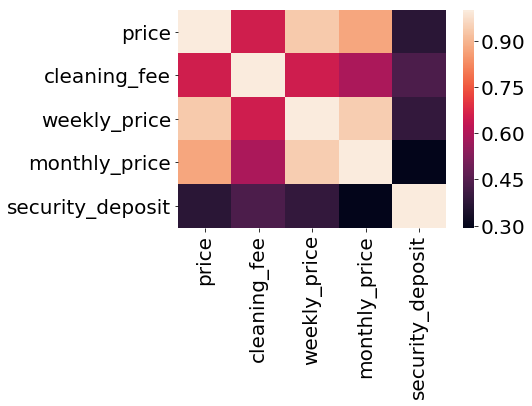

In [716]:
sns.heatmap(corr)

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)


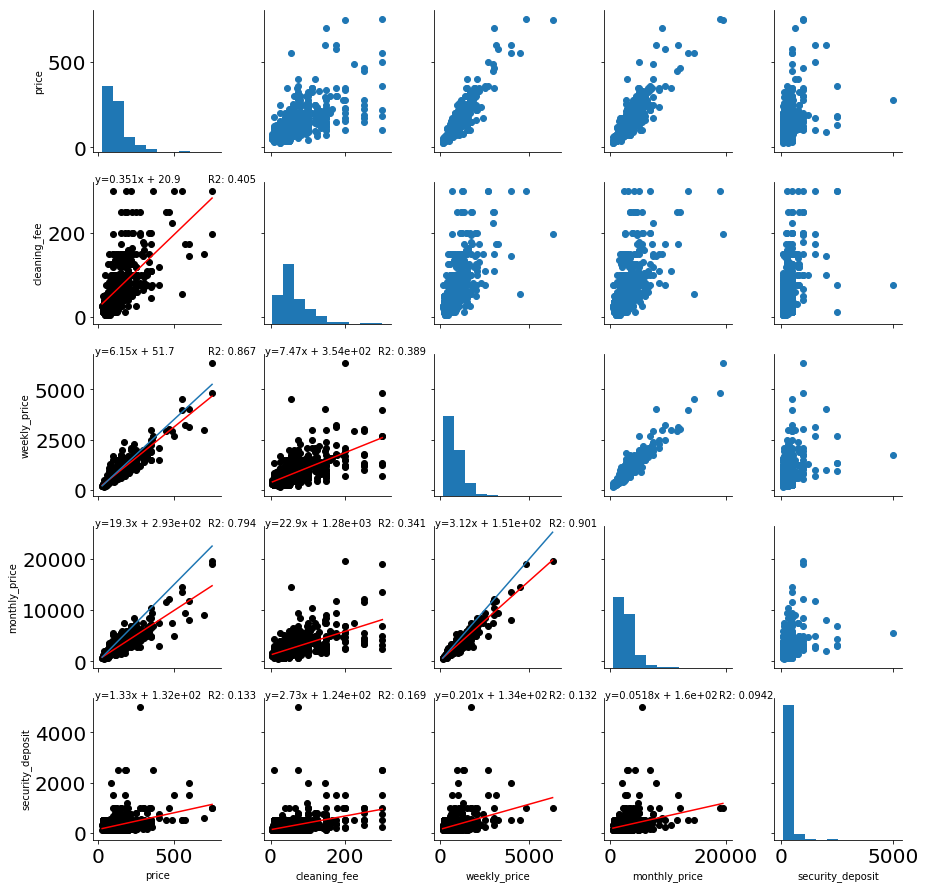

In [717]:
def regplot(x, y, label, color, **kwargs):
    plt.scatter(x, y, c='k')
    name = x.name

    x_reg = pd.Series(data= np.linspace(np.min(x),np.max(x), num=20), name=x.name)
    
    x_reg = sm.add_constant(x_reg)
    print(x_reg.shape)
    x = sm.add_constant(x)    
    mod = sm.OLS(y, x, has_constant ='add')
    res = mod.fit()
#     print(res.summary())
#     print(x_reg, res.predict(x_reg))
    
    plt.plot(x_reg[name], res.predict(x_reg), 'r')
    plt.annotate("R2: {:.3}".format(res.rsquared), xy=(0.9, 1), xycoords='axes fraction')
    plt.annotate("y={:.3}x + {:.3}".format(res.params[name], res.params['const']), xy=(0.01, 1), xycoords='axes fraction')
    if name == 'price':
        if y.name == 'weekly_price':
            plt.plot(x_reg[name], 7*x_reg[name], label='7xprice')
        if y.name == 'monthly_price':
            plt.plot(x_reg[name], 30*x_reg[name], label='30xprice')
        
    if name == 'weekly_price' and y.name=='monthly_price':
        plt.plot(x_reg[name], 4*x_reg[name], label='4xweekly price')
        
    plt.legend()
    return res
    
    


g = sns.PairGrid(data=df_seattle_list_reduced.dropna(axis=0, how='any', subset=price_cols)[price_cols])
g.map_upper(plt.scatter)
g.map_diag(plt.hist)
g.map_lower(regplot)



From the above plot it shows a fairly consistent relationship between the daily, weekly and monthly prices. However, it is interesting to see that in all cases, and especially for the monthly price, some houses and appartments takes a premium to rent for a fixed period. It would often be the customer who gets a premium for fixing a given length, or longer time. 

The lower half of the matrix shows the scatter data with overlay of the linear regression line fitted to the data in blue, and a multiple of the x-axis (7xprice = weekly price, 30xprice = monthly price and 4xweekly price = monthly price). This is where we can see that although the average trend in lower price for a longer fixation of the rental, some appartments operate with higher prices. 

We also see that cleaning fees are not possible to correlate with the price of the appartment. They may have a slight trend, but the distribution is wide for all prices for the appartment. However, it can look like people are using round numbers. 


Anyway, we will use the found relationships to impute values for the appartments. 

In [718]:
def impute_prices(df, basis_col='price', impute_to=['weekly_price', 'monthly_price']):
    #Build models based on existing values
    for col in impute_to:
        x = sm.add_constant(df.dropna(axis=0, how='any', subset=[basis_col,col])[basis_col])
        y = df.dropna(axis=0, how='any', subset=[basis_col,col])[col]
#         print(x, y)
        model = sm.OLS(y,x).fit()
#         print(model.summary())
        preds = model.predict(sm.add_constant(df[basis_col]))
#         print(preds)
        df.loc[df[col].isnull(),col] = preds[df[col].isnull()]
    return df
        
df_seattle_cleaned = impute_prices(df_seattle_list_reduced.copy())
df_seattle_cleaned = df_seattle_cleaned.drop(['cleaning_fee','security_deposit'], axis=1)

However, some of these columns and the missing data and what to do with it will depend on what we are trying to find out. So, lets go looking for some questions about the data. 


One interesting question is related to the pricing of weekly and monthly prices. Is there something about the appartments or hosts that takes a premium on the weekly prices? Is there something interesting about the rental for those appartments or houses, do they have more days a year rental?

(20, 2)


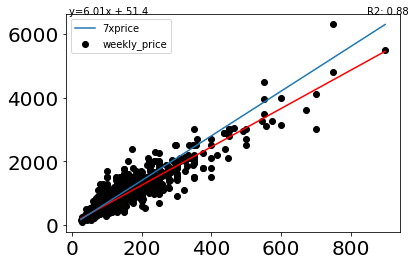

In [719]:
x= df_seattle_list_reduced.dropna(axis=0, how='any', subset=['weekly_price'])['price']
y= df_seattle_list_reduced.dropna(axis=0, how='any', subset=['weekly_price'])['weekly_price']
week_res = regplot(x, y, 'fe', 'efw')

In [720]:
week_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           weekly_price   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                 1.466e+04
Date:                Sun, 05 May 2019   Prob (F-statistic):               0.00
Time:                        17:30:11   Log-Likelihood:                -13335.
No. Observations:                2009   AIC:                         2.667e+04
Df Residuals:                    2007   BIC:                         2.669e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.3574      7.352      6.985      0.000      36.938      65.777
price          6.0079      0.050    121.079      0.000       5.911       6.105
==============================================================================
Omnibus:                      686.226   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11995.980
Skew:                           1.142   Prob(JB):                         0.00
Kurtosis:                      14.751   Cond. No.                         264.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.2, 0.9741164758586361, '2.6% of appartments\n charge 40% margin or more')

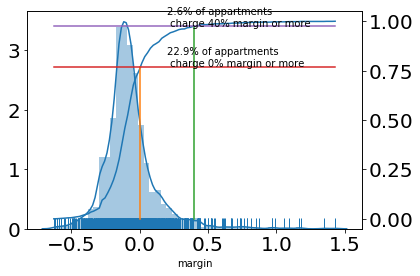

In [721]:
#df_weekly_premium = df_seattle_list_reduced[df_seattle_list_reduced['weekly_price']>res.predict(sm.add_constant(df_seattle_list_reduced['price']))]
weekly_premium = pd.DataFrame({'weekly_price':df_seattle_list_reduced['weekly_price'], 
              'regression_weekly_price': week_res.predict(sm.add_constant(df_seattle_list_reduced['price'])), 
              '7x line' : df_seattle_list_reduced['price']*7,
              'margin' : (df_seattle_list_reduced['weekly_price']/(df_seattle_list_reduced['price']*7))-1,
              'premium?': df_seattle_list_reduced['weekly_price']>week_res.predict(sm.add_constant(df_seattle_list_reduced['price']))})

ax = sns.distplot(weekly_premium['margin'].dropna(), bins=50, rug=True)
cdf = sm.distributions.ECDF(weekly_premium['margin'].dropna())
ax2 = plt.twinx(ax)
x_cdf = np.linspace(min(weekly_premium['margin'].dropna()), max(weekly_premium['margin'].dropna()),100)
ax2.plot(x_cdf, cdf(x_cdf))
weekly_premium.describe()

ax2.plot((0,0),(0,cdf(0)))
ax2.plot((0.4,0.4),(0,cdf(0.4)))
ax2.plot((min(x_cdf),max(x_cdf)),(cdf(0),cdf(0)))
ax2.plot((min(x_cdf),max(x_cdf)),(cdf(0.4),cdf(0.4)))
ax2.annotate('{:.1f}% of appartments\n charge {}% margin or more'.format((1-cdf(0))*100,0), (.2, cdf(0)))
ax2.annotate('{:.1f}% of appartments\n charge {}% margin or more'.format((1-cdf(0.4))*100,40), (.2, cdf(0.4)))


As can be seen from the distribution plot above, we found the weekly price compared to a 7x daily price and found the margin for each of them and plotting the distribution of the margin. In addition, the cummulative distribution is plotted at the right y-axis to give insight on what % of flats are lower than a certain margin. 


We see that 22.9% of the appartments with a given weekly price charge a premium on their appratment to book for a full week compared to the daily given price. A mere 2.6% is charging more than 40% premium on their listing. 

So who are they? 

Well, lets look at the monthly prices first compared to the daily price and a 30 day average month. 

(20, 2)


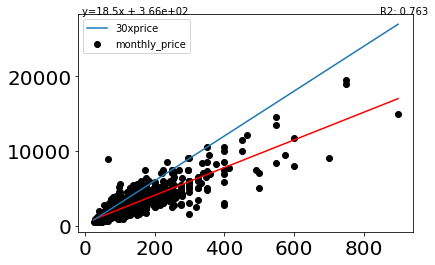

In [722]:
x= df_seattle_list_reduced.dropna(axis=0, how='any', subset=['monthly_price'])['price']
y= df_seattle_list_reduced.dropna(axis=0, how='any', subset=['monthly_price'])['monthly_price']
res = regplot(x, y, 'fe', 'efw')

In [723]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          monthly_price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     4875.
Date:                Sun, 05 May 2019   Prob (F-statistic):               0.00
Time:                        17:30:12   Log-Likelihood:                -12364.
No. Observations:                1517   AIC:                         2.473e+04
Df Residuals:                    1515   BIC:                         2.474e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        365.5950     38.733      9.439      0.000     289.619     441.571
price         18.5110      0.265     69.822      0.000      17.991      19.031
==============================================================================
Omnibus:                      425.015   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7775.017
Skew:                           0.824   Prob(JB):                         0.00
Kurtosis:                      13.968   Cond. No.                         263.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.2, 0.9241924851680949, '7.6% of appartments\n charge 0% margin or more')

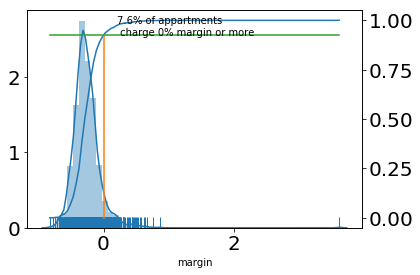

In [724]:
weekly_premium = pd.DataFrame({'monthly_price':df_seattle_list_reduced['monthly_price'], 
              'estimate': res.predict(sm.add_constant(df_seattle_list_reduced['price'])), 
              '30x line' : df_seattle_list_reduced['price']*30,
              'margin' : (df_seattle_list_reduced['monthly_price']/(df_seattle_list_reduced['price']*30))-1,
              'premium?': df_seattle_list_reduced['monthly_price']>res.predict(sm.add_constant(df_seattle_list_reduced['price']))})

ax = sns.distplot(weekly_premium['margin'].dropna(), bins=50, rug=True)
cdf = sm.distributions.ECDF(weekly_premium['margin'].dropna())
ax2 = plt.twinx(ax)
x_cdf = np.linspace(min(weekly_premium['margin'].dropna()), max(weekly_premium['margin'].dropna()),100)
ax2.plot(x_cdf, cdf(x_cdf))
weekly_premium.describe()

ax2.plot((0,0),(0,cdf(0)))
ax2.plot((min(x_cdf),max(x_cdf)),(cdf(0),cdf(0)))
ax2.annotate('{:.1f}% of appartments\n charge {}% margin or more'.format((1-cdf(0))*100,0), (.2, cdf(0)))


So, apparently, the amount of appartments charging a premium for monthly bookings are much less. However, lets start with the weekly and see if we can find out something about them. 

One hypothesis is that the appartments charging a weekly premium is very popular, high ratings, central etc. 

Another is that the host are professional and have multiple listings.

Also, it will be interesting to see if there is a certain trade mark for the listings offering a weekly or monthly price vs the once that does not! 

In [725]:
df_seattle_list['last_scraped'].unique()

array(['2016-01-04'], dtype=object)

In [726]:
df = df_seattle_list_reduced.dropna(subset=['weekly_price'])

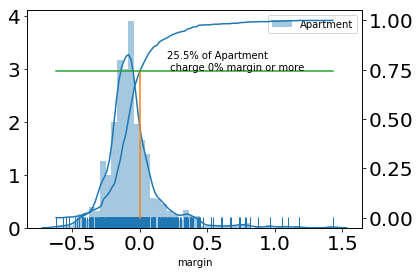

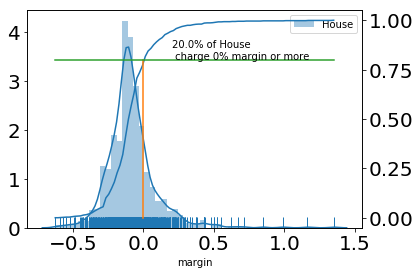

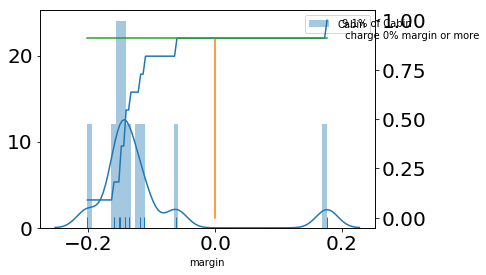

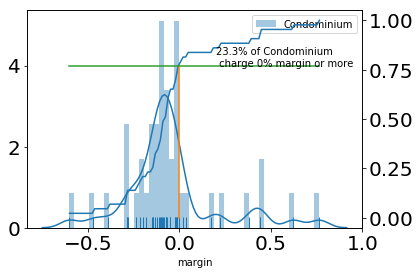

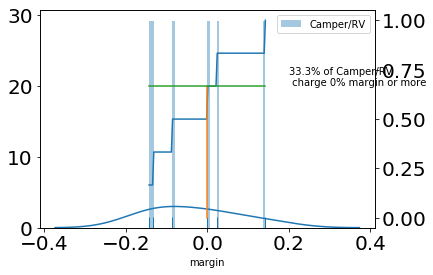

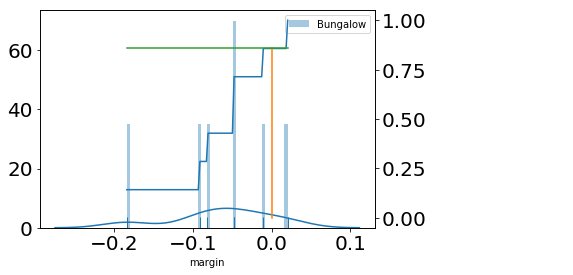

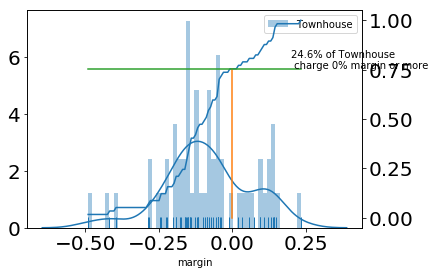

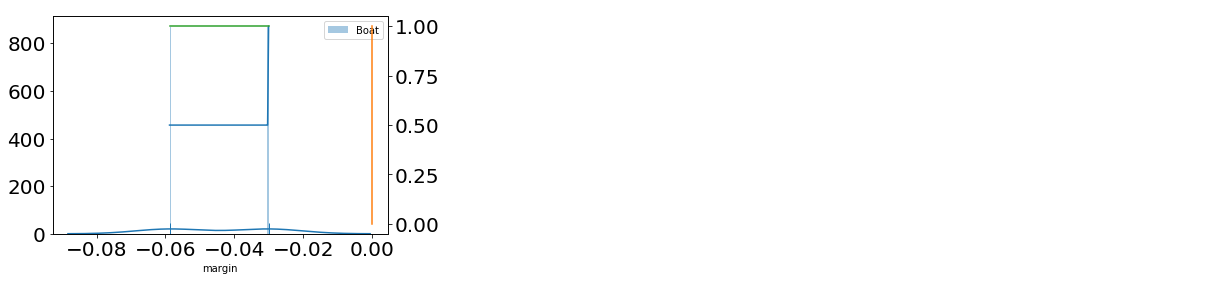

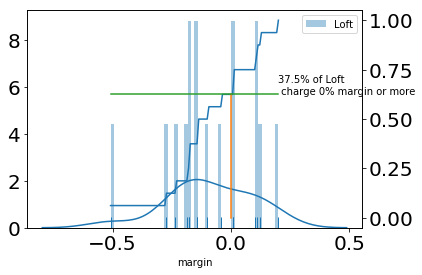

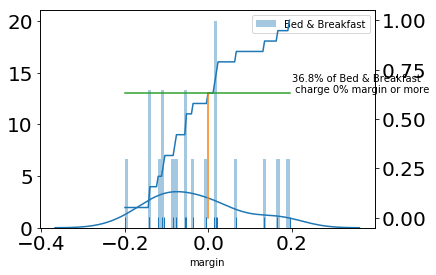

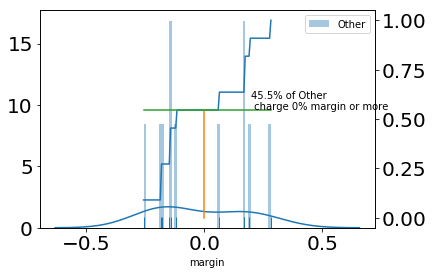

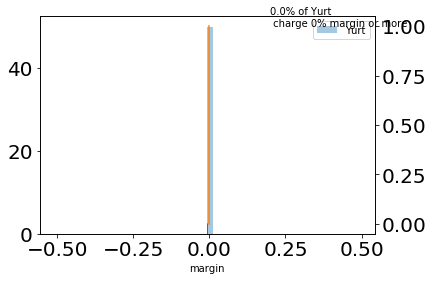

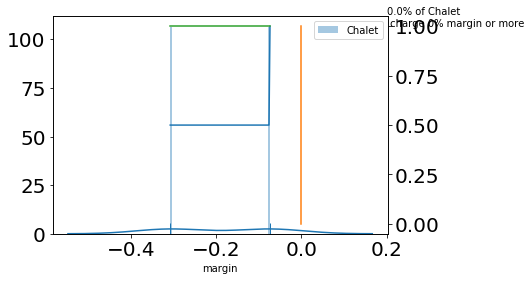

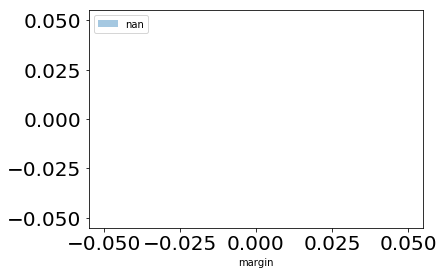

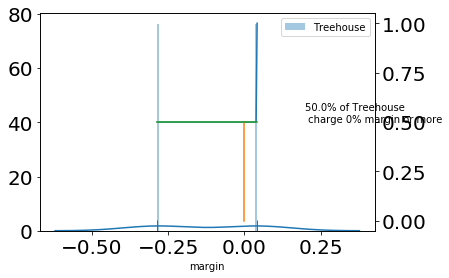

In [727]:
weekly_premium = pd.DataFrame({'regression_weekly_price': week_res.predict(sm.add_constant(df_seattle_list_reduced['price'])), 
              '7x line' : df_seattle_list_reduced['price']*7,
              'margin' : (df_seattle_list_reduced['weekly_price']/(df_seattle_list_reduced['price']*7))-1,
              'premium': df_seattle_list_reduced['weekly_price']>week_res.predict(sm.add_constant(df_seattle_list_reduced['price']))})
df_weekly = pd.concat([df_seattle_list_reduced, weekly_premium], axis=1)
df_weekly
df_weekly_drop = df_weekly.dropna(axis=0, how='any', subset=['weekly_price'])
df_weekly_drop
for ptype in df_weekly_drop['property_type'].unique():
#     print(df_weekly_drop['property_type'] == ptype)
    try:
        fig, ax = plt.subplots(1,1)
        sns.distplot(df_weekly_drop[df_weekly_drop['property_type'] == ptype]['margin'], bins=50, rug=True, ax = ax, label=ptype)
        ax.legend()
        cdf = sm.distributions.ECDF(df_weekly_drop[df_weekly_drop['property_type'] == ptype]['margin'])
        ax2 = plt.twinx(ax)
        xmin = min(df_weekly_drop[df_weekly_drop['property_type'] == ptype]['margin'])
        xmax = max(df_weekly_drop[df_weekly_drop['property_type'] == ptype]['margin'])
        x_cdf = np.linspace(xmin, xmax,100)
        ax2.plot(x_cdf, cdf(x_cdf))
        ax2.plot((0,0),(0,cdf(0)))
        ax2.plot((min(x_cdf),max(x_cdf)),(cdf(0),cdf(0)))
        ax2.annotate('{:.1f}% of {}\n charge {}% margin or more'.format((1-cdf(0))*100,ptype,0),  (.2, cdf(0)))
    except ZeroDivisionError:
        continue
        

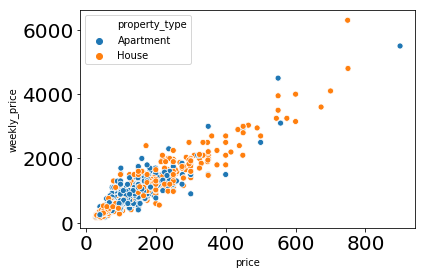

In [728]:
sns.scatterplot(x='price', y='weekly_price', hue='property_type', data=df_weekly_drop[df_weekly_drop['property_type'].isin(['Apartment', 'House'])])

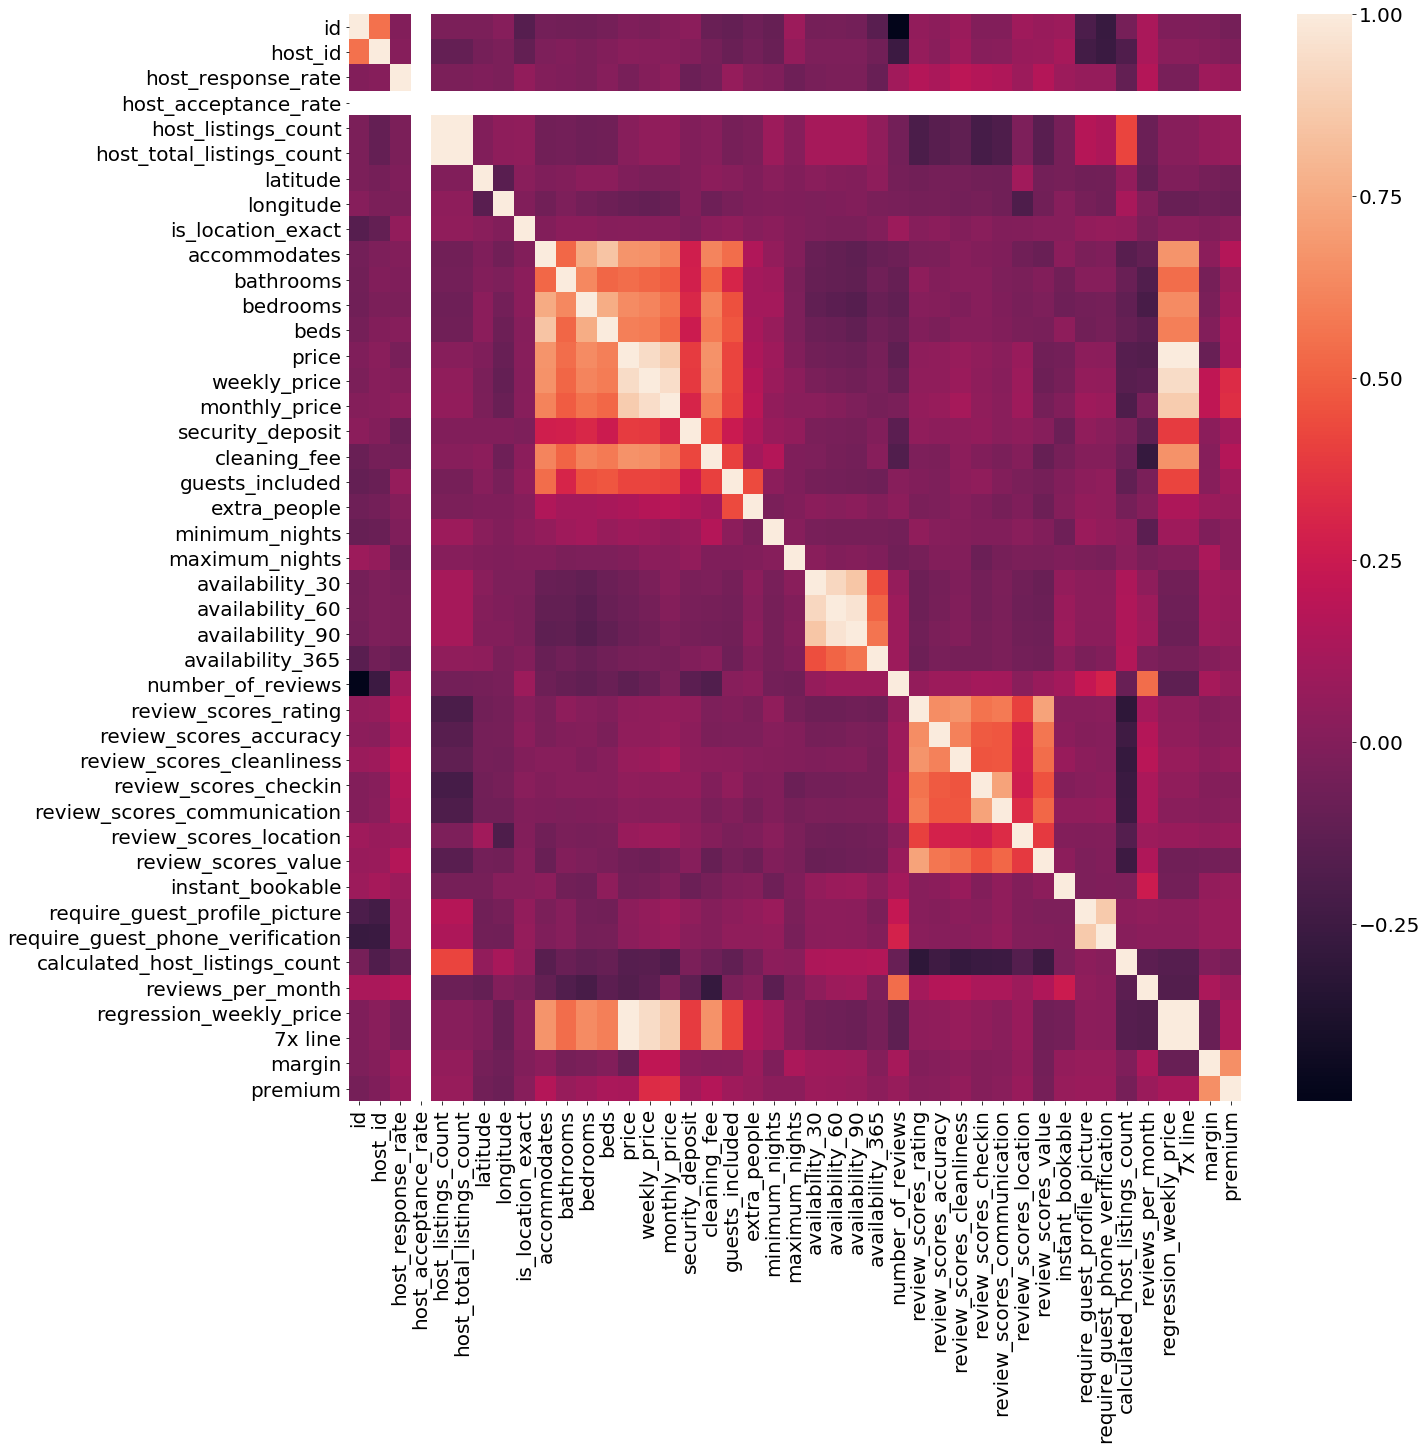

In [729]:
corr = df_weekly_drop.corr()
# print(corr.premium.sort_values())
fig, ax = plt.subplots(1,1, figsize=(20,20))
sns.heatmap(corr)


id  host_id  host_since  host_response_time  \
property_type room_type                                                        
Apartment     Entire home/apt  1428     1428        1426                1247   
              Private room      229      229         229                 184   
              Shared room        51       51          51                  43   
House         Entire home/apt   894      894         894                 766   
              Private room      784      784         784                 674   
              Shared room        55       55          55                  54   
Townhouse     Entire home/apt    54       54          54                  47   
              Private room       62       62          62                  53   
              Shared room         2        2           2                   2   

                               host_response_rate  host_acceptance_rate  \
property_type room_type                                                   
Apartment     Entire home/apt                1247                  1174   
              Private room                    184                   164   
              Shared room                      43                    42   
House         Entire home/apt                 766                   696   
              Private room                    674                   621   
              Shared room                      54                    54   
Townhouse     Entire home/apt                  47                    41   
              Private room                     53                    48   
              Shared room                       2                     2   

                               host_is_superhost  host_listings_count  \
property_type room_type                                                 
Apartment     Entire home/apt               1426                 1426   
              Private room                   229                  229   
              Shared room                     51                   51   
House         Entire home/apt                894                  894   
              Private room                   784                  784   
              Shared room                     55                   55   
Townhouse     Entire home/apt                 54                   54   
              Private room                    62                   62   
              Shared room                      2                    2   

                               host_total_listings_count  host_verifications  \
property_type room_type                                                        
Apartment     Entire home/apt                       1426                1428   
              Private room                           229                 229   
              Shared room                             51                  51   
House         Entire home/apt                        894                 894   
              Private room                           784                 784   
              Shared room                             55                  55   
Townhouse     Entire home/apt                         54                  54   
              Private room                            62                  62   
              Shared room                              2                   2   

                               host_identity_verified  neighbourhood  \
property_type room_type                                                
Apartment     Entire home/apt                    1426           1276   
              Private room                        229            195   
              Shared room                          51             41   
House         Entire home/apt                     894            813   
              Private room                        784            694   
              Shared room                          55             49   
Townhouse     Entire home/apt                      54            

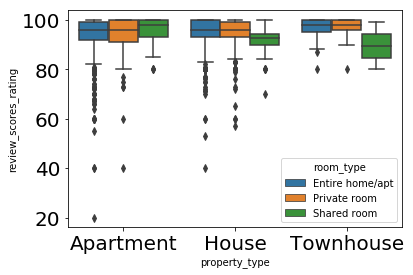

In [730]:
data = df_seattle_list_reduced[df_seattle_list_reduced['property_type'].isin(['Apartment', 'House', 'Townhouse'])]

sns.boxplot(x='property_type', y='review_scores_rating', hue='room_type', data=data)


df_seattle_list_reduced[df_seattle_list_reduced['property_type'].isin(['Apartment', 'House', 'Townhouse'])].groupby(by=['property_type', 'room_type']).count()


In [731]:
df_seattle_list_reduced[df_seattle_list_reduced['property_type'].isin(['Apartment', 'House', 'Townhouse'])].groupby(by=['property_type', 'room_type']).median()[['number_of_reviews','review_scores_rating']]

number_of_reviews  review_scores_rating
property_type room_type                                               
Apartment     Entire home/apt                9.0                  96.0
              Private room                   8.0                  96.0
              Shared room                    4.0                  98.0
House         Entire home/apt                7.0                  96.0
              Private room                  14.0                  96.0
              Shared room                    4.0                  92.5
Townhouse     Entire home/apt                3.0                  98.0
              Private room                   3.5                  98.0
              Shared room                    9.5                  89.5

In [732]:
df_seattle_list_reduced[df_seattle_list_reduced['property_type'].isin(['Apartment', 'House', 'Townhouse'])].groupby(by=['property_type', 'room_type']).mean()[['number_of_reviews','review_scores_rating']]


number_of_reviews  review_scores_rating
property_type room_type                                               
Apartment     Entire home/apt          21.211485             93.984140
              Private room             22.567686             93.638743
              Shared room              15.176471             95.435897
House         Entire home/apt          20.300895             94.927536
              Private room             27.747449             94.954338
              Shared room              10.763636             91.409091
Townhouse     Entire home/apt           9.074074             96.342857
              Private room              9.838710             97.186047
              Shared room               9.500000             89.500000

In [733]:
df_seattle_list_reduced[df_seattle_list_reduced['property_type'].isin(['Apartment', 'House', 'Townhouse'])].groupby(by=['property_type', 'room_type']).count()[['number_of_reviews','review_scores_rating']]

number_of_reviews  review_scores_rating
property_type room_type                                               
Apartment     Entire home/apt               1428                  1198
              Private room                   229                   191
              Shared room                     51                    39
House         Entire home/apt                894                   759
              Private room                   784                   657
              Shared room                     55                    44
Townhouse     Entire home/apt                 54                    35
              Private room                    62                    43
              Shared room                      2                     2

In [781]:
df_seattle_list_reduced.columns

Index(['id', 'host_id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode',
       'latitude', 'longitude', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'revie

In [748]:
mean_neighborhood = df_seattle_list_reduced.groupby('neighbourhood_group_cleansed').mean().reset_index()
mean_neighborhood


neighbourhood_group_cleansed            id       host_id  \
0                       Ballard  5.180190e+06  1.498283e+07   
1                   Beacon Hill  5.052427e+06  1.502024e+07   
2                  Capitol Hill  5.668931e+06  1.698144e+07   
3                       Cascade  6.089536e+06  1.703599e+07   
4                  Central Area  5.587679e+06  1.618958e+07   
5                      Delridge  5.217371e+06  1.635080e+07   
6                      Downtown  5.683918e+06  1.426956e+07   
7                      Interbay  5.872783e+06  1.498236e+07   
8                     Lake City  5.432238e+06  1.542281e+07   
9                      Magnolia  5.704966e+06  1.564218e+07   
10                    Northgate  5.566178e+06  1.710862e+07   
11          Other neighborhoods  5.235195e+06  1.472019e+07   
12                   Queen Anne  5.921983e+06  1.839227e+07   
13               Rainier Valley  5.282222e+06  1.572896e+07   
14                  Seward Park  5.548881e+06  1.635144e+07   
15          University District  6.414587e+06  1.518129e+07   
16                 West Seattle  5.752459e+06  1.660374e+07   

    host_response_rate  host_acceptance_rate  host_listings_count  \
0             0.951765              1.000000             5.004348   
1             0.959810              1.000000             2.822034   
2             0.953516              0.997748             4.795414   
3             0.890303              1.000000             3.483146   
4             0.938875              1.000000             1.997290   
5             0.970154              1.000000             1.341772   
6             0.942316              1.000000            25.354167   
7             0.998000              1.000000             2.090909   
8             0.977115              1.000000             6.791045   
9             0.929455              1.000000             2.278689   
10            0.947286              1.000000             1.862500   
11            0.953824              1.000000             5.324937   
12            0.948415              1.000000             2.077966   
13            0.964214              1.000000             4.716981   
14            0.931026              1.000000             2.977273   
15            0.910561              1.000000            13.467213   
16            0.969306              1.000000             2.167488   

    host_total_listings_count   latitude   longitude  is_location_exact  \
0                    5.004348  47.674525 -122.380150           0.900000   
1                    2.822034  47.569667 -122.306754           0.847458   
2                    4.795414  47.623578 -122.316462           0.888889   
3                    3.483146  47.633757 -122.331631           0.887640   
4                    1.997290  47.607715 -122.301760           0.899729   
5                    1.341772  47.545983 -122.362599           0.898734   
6                   25.354167  47.611406 -122.337498           0.854717   
7                    2.090909  47.641729 -122.382653           0.818182   
8                    6.791045  47.712153 -122.293985           0.910448   
9                    2.278689  47.649268 -122.395518           0.918033   
10                   1.862500  47.702454 -122.325100           0.887500   
11                   5.324937  47.670646 -122.335808           0.919395   
12                   2.077966  47.634047 -122.357751           0.905085   
13                   4.716981  47.554471 -122.281401           0.924528   
14                   2.977273  47.554276 -122.268686           1.000000   
15                  13.467213  47.662874 -122.314214           0.868852   
16                   2.167488  47.561976 -122.390300           0.862069   

    accommodates  bathrooms  bedrooms      beds       price  weekly_price  \
0       3.443478   1.289130  1.434783  1.847826  124.682609    802.248000   
1       2.991525   1.230769  1.262712  1.627119   94.669492    649.160000   
2       2.989418   1.265957  1.139823  1.53

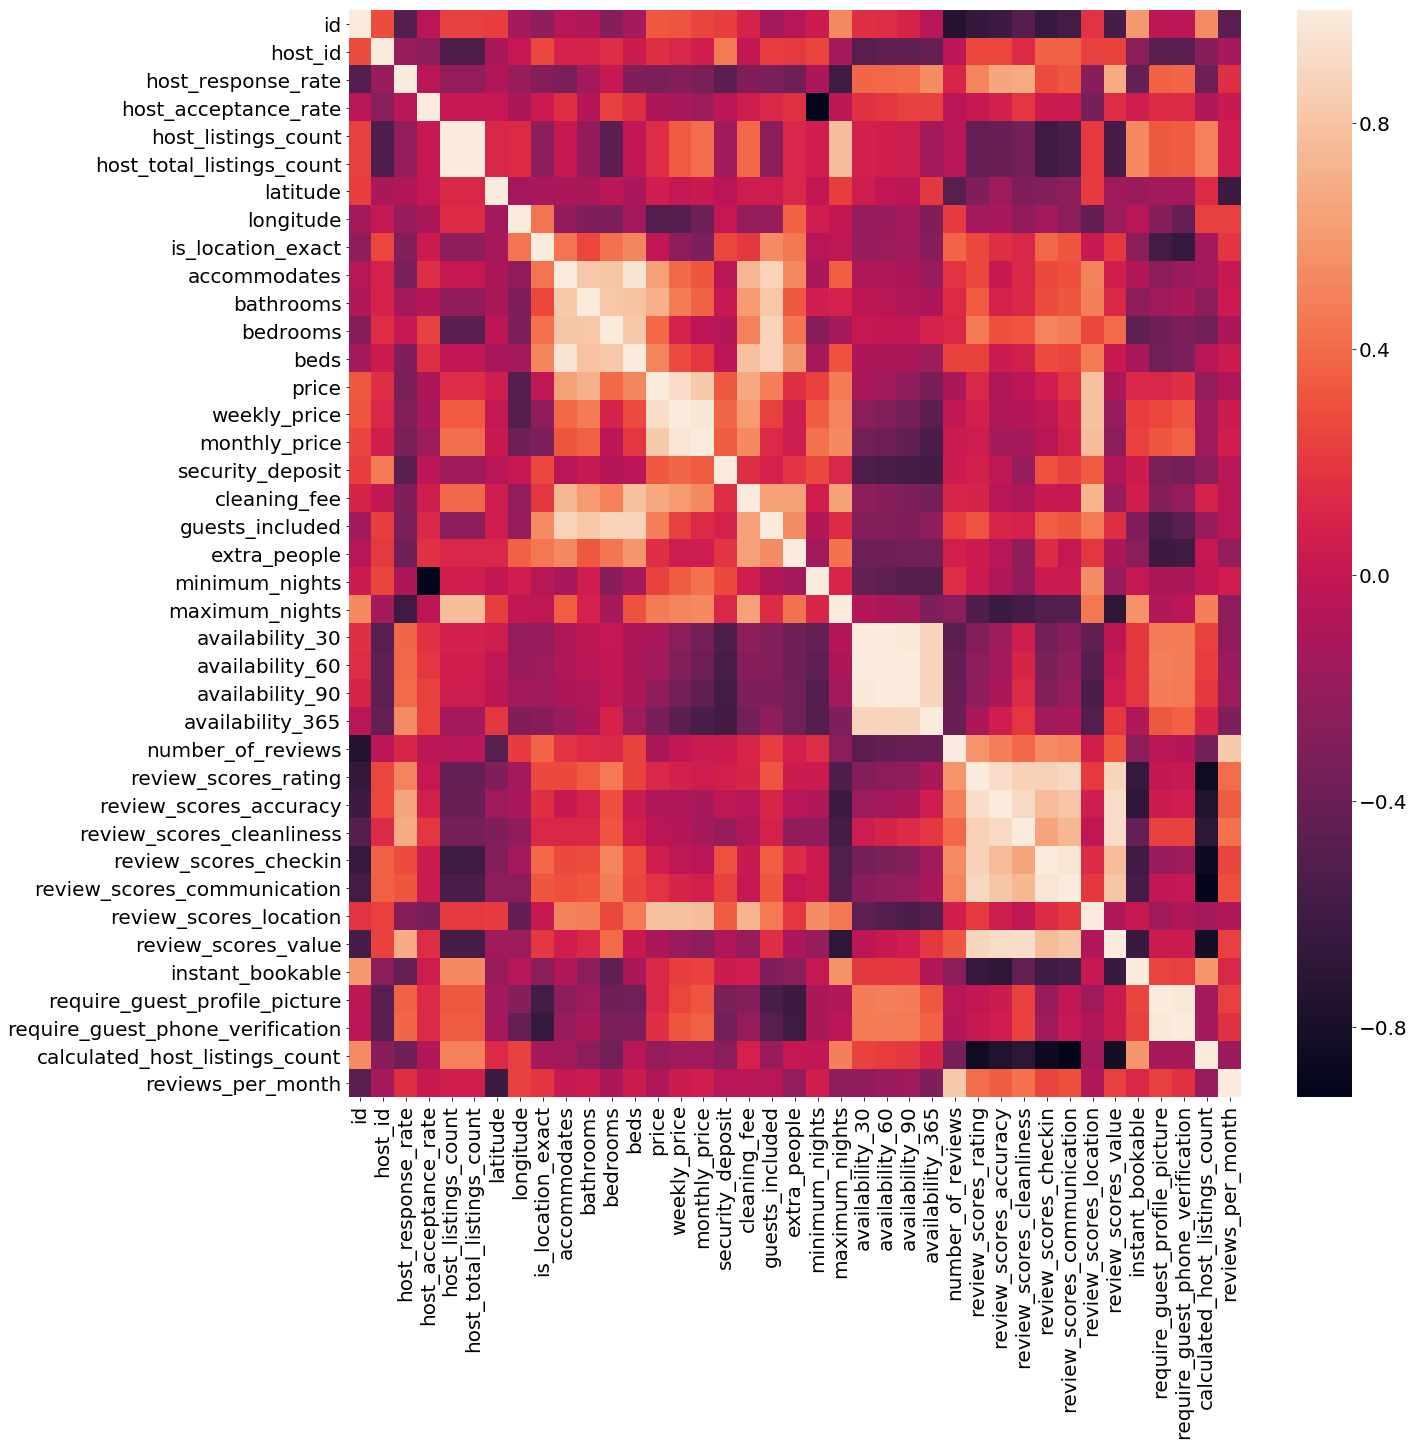

In [793]:
corr = mean_neighborhood.corr()
fig, ax = plt.subplots(1,1, figsize=(20,20))
sns.heatmap(corr, ax = ax)

In [782]:
mean_neighborhood_2 = df_seattle_list_reduced.groupby('neighbourhood').mean().reset_index()
mean_neighborhood_2

neighbourhood            id       host_id  host_response_rate  \
0                        Alki  5.513224e+06  1.568420e+07            0.988421   
1               Arbor Heights  3.961523e+06  9.899291e+06            1.000000   
2                    Atlantic  5.267910e+06  1.734774e+07            0.945581   
3                     Ballard  4.924953e+06  1.432290e+07            0.953613   
4                    Belltown  5.288179e+06  1.187108e+07            0.938783   
5                 Bitter Lake  4.873412e+06  1.509294e+07            0.955556   
6                    Brighton  6.612498e+06  2.025348e+07            1.000000   
7                   Broadview  4.494327e+06  1.408303e+07            0.992308   
8                    Broadway  5.562132e+05  2.207233e+06            1.000000   
9                      Bryant  5.354702e+06  1.786997e+07            0.934286   
10               Capitol Hill  5.375788e+06  1.595114e+07            0.949931   
11                 Cedar Park  5.564411e+06  1.552788e+07            1.000000   
12  Central Business District  5.212518e+06  1.401878e+07            0.928734   
13              Columbia City  4.567016e+06  1.278976e+07            0.946667   
14                 Crown Hill  4.816342e+06  1.279213e+07            0.974118   
15                     Dunlap  5.409829e+06  1.709284e+07            0.952000   
16                   Eastlake  5.005538e+06  1.176392e+07            0.918966   
17             Fairmount Park  6.920800e+05  2.053250e+05                 NaN   
18                 Fauntleroy  4.818912e+06  2.280942e+07            0.988889   
19                 First Hill  5.500051e+06  1.669532e+07            0.975368   
20                    Fremont  5.328131e+06  1.428356e+07            0.953437   
21                   Gatewood  5.559140e+06  2.161841e+07            0.964286   
22                    Genesee  6.435932e+06  1.602797e+07            1.000000   
23                 Georgetown  4.210055e+06  6.413533e+06            1.000000   
24                 Green Lake  4.472549e+06  1.641781e+07            0.975111   
25                  Greenwood  5.318723e+06  1.386164e+07            0.974697   
26                Haller Lake  5.544884e+06  1.621858e+07            0.992308   
27      Harrison/Denny-Blaine  4.194398e+06  8.710706e+06            0.883333   
28                 High Point  5.945024e+06  2.405270e+07            1.000000   
29              Highland Park  3.801603e+06  1.005749e+07            0.933000   
30                 Holly Park  6.008859e+06  2.480542e+07            1.000000   
31        Industrial District  4.869863e+06  1.805681e+07            1.000000   
32                   Interbay  5.243884e+06  1.035418e+07            1.000000   
33     International District  5.274673e+06  1.295954e+07            0.974706   
34                Laurelhurst  5.577819e+06  1.612961e+07            1.000000   
35                     Leschi  5.774903e+06  2.380794e+07            0.933333   
36             Licton Springs  6.086982e+06  1.691127e+07            0.980000   
37           Lower Queen Anne  6.274697e+06  2.115141e+07            0.968485   
38               Madison Park  6.569384e+06  2.646765e+07            0.953571   
39                    Madrona  5.860171e+06  1.657040e+07            0.946875   
40                   Magnolia  5.623899e+06  1.592028e+07            0.940800   
41                 Maple Leaf  5.277423e+06  1.687219e+07            0.924474   
42              Mathews Beach  5.182103e+06  1.624912e+07            0.978000   
43                Meadowbrook  6.385383e+06  1.943537e+07            1.000000   
44                      Minor  5.270846e+06  1.346504e+07            0.947457   
45                   Montlake  5.585920e+06  1.537860e+07            0.988667   
46                Mount Baker  5.174633e+06  1.789718e+07            0.984146   
47              North Admiral  5.264809e+06  1.467325e+07            0.956667   
48     North Beach/Blue Ridge  6.355922e+06  2.

In [ ]:
mean_neighborhood_2 = df_seattle_list_reduced.groupby('neighbourhood').mean().reset_index()

In [800]:


def plot_map(df, loc, data_col, prefix=None):
    neighborhoods_json = os.path.join("seattle_neighborhoods.geojson")
    m = folium.Map(location=[47.662569, -122.314040], zoom_start=12)
    
    if loc == 'neighborhood':
        keyon = 'feature.properties.nested'
    elif loc == 'neighbourhood_group_cleansed':
        keyon = 'feature.properties.nhood'
    else:
        return None
        
    m.choropleth(
        geo_data=neighborhoods_json,
        name='choropleth',
        data=df,
        columns=[loc, data_col],
        key_on=keyon,
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name= data_col
    )
    folium.LayerControl().add_to(m)
    if prefix:
        m.save('{}_{}.html'.format(prefix, data_col))
    else:
        m.save('{}.html'.format(data_col))


In [801]:
for col in mean_neighborhood.drop('neighbourhood_group_cleansed', axis=1):
    plot_map(mean_neighborhood, 'neighbourhood_group_cleansed', col, 'NGroup')